# **VAE Model**

### **i. Imports and subfunctions**

In [3]:
# Imports
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torch.utils.data import Subset, DataLoader, random_split
from torchvision import transforms, datasets
from torchvision import transforms, datasets

def split_iid(dataset, n_centers):
    """ Split PyTorch dataset randomly into n_centers."""
    n_obs_per_center = [len(dataset) // n_centers for _ in range(n_centers)]
    return random_split(dataset, n_obs_per_center)

def federated_averaging(models, n_obs_per_client):
    """ Perform federated averaging."""
    # Error check inputs
    assert len(models) > 0
    assert len(n_obs_per_client) == len(models)

    # Compute proportions
    n_obs = sum(n_obs_per_client)
    proportions = [n_k / n_obs for n_k in n_obs_per_client]

    # Empty model parameter dictionary
    avg_params = models[0].state_dict()
    for key, val in avg_params.items():
        avg_params[key] = torch.zeros_like(val)

    # Compute average
    for model, proportion in zip(models, proportions):
        for key in avg_params.keys():
            avg_params[key] += proportion * model.state_dict()[key]

    # Copy one of the models and load trained params
    avg_model = copy.deepcopy(models[0])
    avg_model.load_state_dict(avg_params)

    return avg_model

def loss_plot(epochs, loss):
    """ Plot loss curve."""
    plt.plot(epochs, loss)
    plt.show()

def show(img):
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))

def denorm(x):
    """ 
    Function to reverse the normalization so that we can visualise the outputs
    """
    unnormalize = transforms.Normalize((0,), (1,))
    x = unnormalize(x)
    return x


### **ii. General setup**

In [16]:
# Training hyperparameters
N_ROUNDS = 10
N_CENTRES = 4
N_EPOCHS = 2
N_FEATURES = 784
batch_size = 3

# GPU settings
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
with torch.no_grad():
    torch.cuda.empty_cache()

# Load data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0,), (1,))])
dataset = datasets.MNIST('~/data/', train=True, download=True, transform=transform)
train_dataset = datasets.MNIST(root="~/torch_datasets", train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root="~/torch_datasets", train=False, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=True)

# Federate data
federated_dataset = split_iid(train_dataset, n_centers=4)
print('Number of centers:', len(federated_dataset))

# Put data into dataloader
for i, dataset in enumerate(federated_dataset):
    federated_dataset[i] = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                       shuffle=True, num_workers=4, pin_memory=True)

Number of centers: 4


## **1. Create models**

In [7]:
class VAE(nn.Module):
    def __init__(self, in_features,
                 latent_dim):
        super(VAE, self).__init__()

        # Assign variables
        self.in_features = in_features
        self.latent_dim = latent_dim
        modules = []

        # Build Encoder
        modules.append(
            nn.Sequential(
                nn.LeakyReLU())
        )

        # Build encoder
        self.encoder = nn.Sequential(*modules)
        self.fc_mu = nn.Linear(in_features, latent_dim)
        self.fc_var = nn.Linear(in_features, latent_dim)

        # Build decoder
        modules = []
        self.decoder_input = nn.Linear(latent_dim, in_features)
        modules.append(
            nn.Sequential(
                nn.LeakyReLU())
        )
        self.decoder = nn.Sequential(*modules)

    def encode(self, x):
        """ Encode input to mean and logvar."""
        # Get values from encoding features
        result = self.encoder(x)
        result = torch.flatten(result, start_dim=1)

        # Split the result into mu and var components
        # of the latent Gaussian distribution
        mu = self.fc_mu(result)
        logvar = self.fc_var(result)

        return [mu, logvar]
    
    def reparameterise(self, mu, logvar):
        """ Reparameterise to sample."""
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu


    def decode(self, z):
        """ Decode latent sampling to output."""
        result = self.decoder_input(z)
        result = self.decoder(result)
        return result

    def forward(self, x):
        """ Forward pass of the network."""
        # Check input length matches in_features
        if x.shape[-1] != self.in_features:
            raise Exception(f'Input features must be equal to {self.in_features}!')

        # Encode input to mean and logvar
        mu, logvar = self.encode(x)

        # Reparameterise
        z = self.reparameterise(mu, logvar)

        # Decode and return values
        return  [self.decode(z), x, mu, logvar]

class AutoEncoder(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.encoder_hidden_layer = nn.Linear(
            in_features=kwargs["input_shape"], out_features=128
        )
        self.encoder_output_layer = nn.Linear(
            in_features=128, out_features=128
        )
        self.decoder_hidden_layer = nn.Linear(
            in_features=128, out_features=128
        )
        self.decoder_output_layer = nn.Linear(
            in_features=128, out_features=kwargs["input_shape"]
        )

    def forward(self, features):
        activation = self.encoder_hidden_layer(features)
        activation = torch.relu(activation)
        code = self.encoder_output_layer(activation)
        code = torch.relu(code)
        activation = self.decoder_hidden_layer(code)
        activation = torch.relu(activation)
        activation = self.decoder_output_layer(activation)
        reconstructed = torch.relu(activation)
        return reconstructed
    
class VAELoss(nn.Module):
    def __init__(self):
        super(VAELoss, self).__init__()
        self.criterion = F.mse_loss

    def forward(self, inputs, outputs, mu, logvar, Beta=5):   
        recons_loss = self.criterion(outputs, inputs)
        kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return recons_loss + (Beta*kl) 

## **2. Train VAE**

In [8]:
# Initialise model
StandardVAE = VAE(N_FEATURES, 5).to(device)
params = sum(p.numel() for p in StandardVAE.parameters() if p.requires_grad)
print("Total number of parameters is: {}".format(params))
print(StandardVAE)

# Optimiser and loss
optimizer = torch.optim.Adam(StandardVAE.parameters(), lr=1e-3)
criterion = VAELoss()

Total number of parameters is: 12554
VAE(
  (encoder): Sequential(
    (0): Sequential(
      (0): LeakyReLU(negative_slope=0.01)
    )
  )
  (fc_mu): Linear(in_features=784, out_features=5, bias=True)
  (fc_var): Linear(in_features=784, out_features=5, bias=True)
  (decoder_input): Linear(in_features=5, out_features=784, bias=True)
  (decoder): Sequential(
    (0): Sequential(
      (0): LeakyReLU(negative_slope=0.01)
    )
  )
)


In [21]:
# Initialise model
StandardVAE.train()
epoch_loss = []
print('Beginning standard VAE training...\n')
for epoch in range(N_EPOCHS): 
    running_loss = 0.0
    for batch_idx, batch in enumerate(train_loader):
        # Batch tensor
        batch_tensor = batch[0].view(batch_size, 784).to(device)

        # Reset the gradients back to zero
        optimizer.zero_grad()

        # Compute reconstructions
        results = StandardVAE(batch_tensor)
        
        # Compute training reconstruction loss
        train_loss = criterion(batch_tensor, results[0], results[2], results[3])

        # Compute accumulated gradients
        train_loss.backward()
        
        # Perform parameter update based on current gradients
        optimizer.step()

        # Update loss
        running_loss += train_loss.item()

        # Loss
        if batch_idx % 1000 == 0:
            print(f'Epoch: {epoch} - Batch: {batch_idx} - Loss: {train_loss}')

    # Average epoch loss
    epoch_loss.append(running_loss/batch_idx+1)

Beginning standard VAE training...



RuntimeError: CUDA error: CUBLAS_STATUS_NOT_INITIALIZED when calling `cublasCreate(handle)`

In [15]:
torch.cuda.current_device()

0

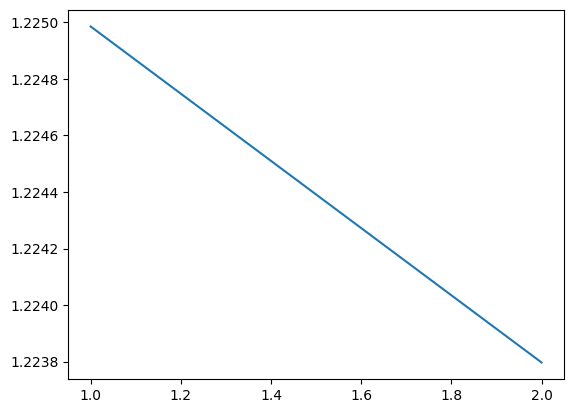

In [ ]:
loss_plot(np.linspace(1, N_EPOCHS, N_EPOCHS).astype(int), epoch_loss)

## **3. Analyse VAE**

Input images
--------------------------------------------------


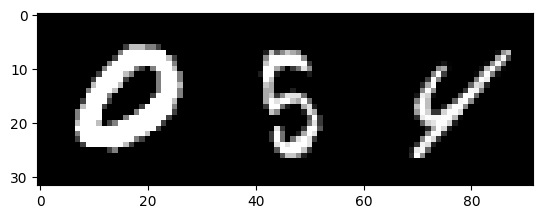

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Reconstructed images
--------------------------------------------------


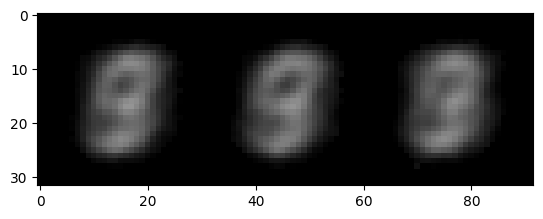

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generated Images
--------------------------------------------------


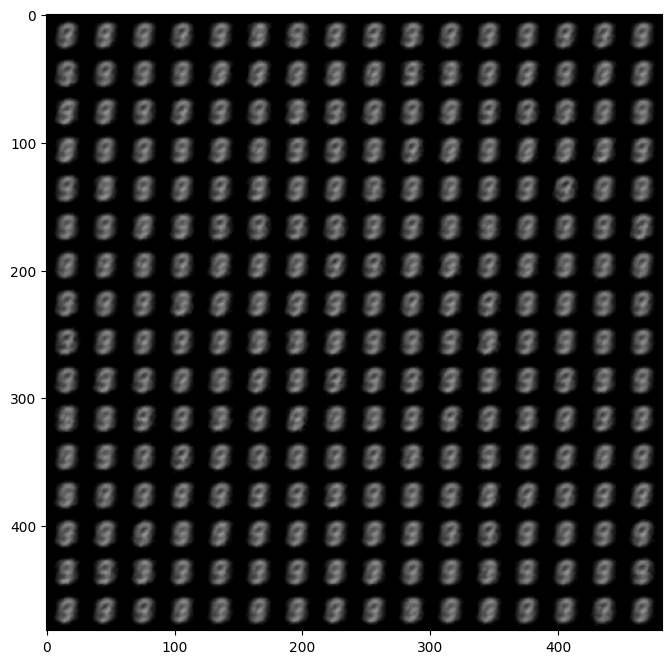

In [39]:
# Visualise original images
print('Input images')
print('-'*50)
sample_inputs, _ = next(iter(test_loader))
fixed_input = sample_inputs[0:32, :, :, :]
img = make_grid(denorm(fixed_input), nrow=8, padding=2, normalize=False,
                range=None, scale_each=False, pad_value=0)
show(img)
plt.show()


print('Reconstructed images')
print('-'*50)
with torch.no_grad():
    # Visualize the reconstructed images of the last batch of test set
    fixed_input = fixed_input.view(batch_size, N_FEATURES).to(device)
    recon_batch = StandardVAE(fixed_input)
    recon_batch = recon_batch[0].cpu()
    recon_batch = recon_batch.view(batch_size, 1, 28, 28)
    recon_batch = make_grid(denorm(recon_batch), nrow=8, padding=2, normalize=False,
                            range=None, scale_each=False, pad_value=0)
    show(recon_batch)
    plt.show()

print('Generated Images')  
print('-'*50)
StandardVAE.eval()
n_samples = 256
z = torch.randn(n_samples, 5).to(device)
with torch.no_grad():
    samples = StandardVAE.decode(z)
    samples = samples.view(n_samples, 1, 28, 28)
    samples = samples.cpu()
    samples = make_grid(denorm(samples), nrow=16, padding=2, normalize=False,
                            range=None, scale_each=False, pad_value=0)
    plt.figure(figsize = (8,8))
    show(samples)



In [ ]:
# Define model paramters and architecture
MyEncoder = AutoEncoder(input_shape=784).to(device)
optimizer = torch.optim.Adam(MyEncoder.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# Copy models over centres
encoders = [copy.deepcopy(MyEncoder) for _ in range(N_CENTRES)]
n_obs_per_client = [len(client_data) for client_data in federated_dataset]